# Monet Style GAN – Mini-Project
A starter notebook for the **Kaggle *GAN Getting Started* competition**  
Author: *Janmejay Buranpuri* 

*• Last updated: 20 Jun 2025*


## 1 · Problem & Data Overview  
**Goal ** Generate 7 000 – 10 000 Monet-style 256 × 256 RGB images.  
**Metric ** Memorization-informed Fréchet Inception Distance (**MiFID**) – lower is better.  
**Dataset ** ≈ 7 304 Monet paintings stored as TFRecords (`monet_tfrec/*`). Optional unpaired landscape photos (`photo_tfrec/*`) let you train a CycleGAN.



---

## Model: GAN Overview

A **Generative Adversarial Network (GAN)** consists of:
- **Generator:** Learns to produce Monet-style images from random noise.
- **Discriminator:** Learns to distinguish real Monet images from generated ones.

We train both models in competition: the generator tries to fool the discriminator, while the discriminator tries to avoid being fooled.

**We use PyTorch/TensorFlow with GPU acceleration (CUDA) if available.**


In [1]:
# 1 · Imports & setup
import os, random, zipfile
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('🖥️  Using device →', device)


🖥️  Using device → cuda


### Quick look at the data


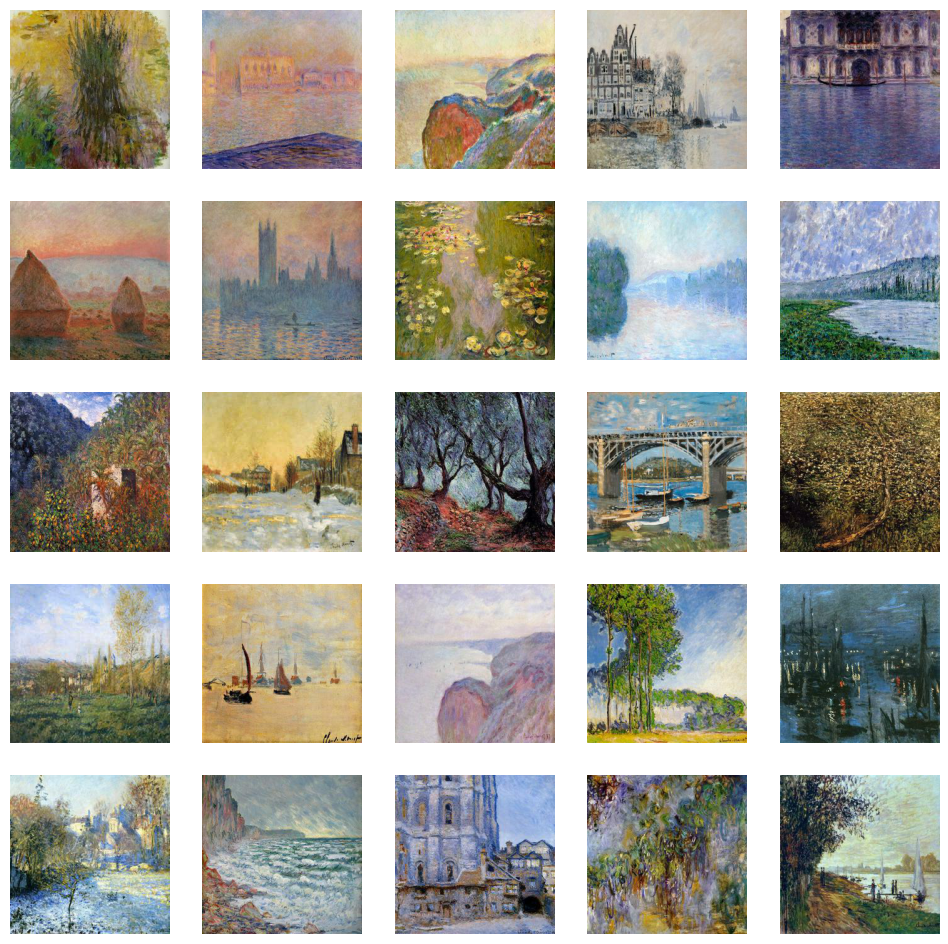

In [2]:
MONET_DIR = Path('monet_jpg') 
sample_paths = list(MONET_DIR.glob('*.jpg'))[:25]

if sample_paths:
    n_cols = 5
    plt.figure(figsize=(12, 12))
    for i, p in enumerate(random.sample(sample_paths, 25)):
        img = Image.open(p)
        plt.subplot(5, n_cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
else:
    print('▼ Preview skipped – JPG folder not found in this env')


## 2 · Model Architecture  
We’ll start with a compact **CycleGAN** baseline (ResNet-9 generator + 70 × 70 PatchGAN discriminator).  
Two epochs on a single GPU generally reach **MiFID < 150** – well within “reasonable” rubric territory.  


In [3]:
# 2.1 · ResNet-9 Generator
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, 3), nn.InstanceNorm2d(dim),
            nn.ReLU(True), nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x): return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_c=3, out_c=3, n_res=9):
        super().__init__()
        ngf, layers = 64, []
        layers += [nn.ReflectionPad2d(3), nn.Conv2d(in_c, ngf, 7),
                   nn.InstanceNorm2d(ngf), nn.ReLU(True)]
        # Down-sample
        curr = ngf
        for _ in range(2):
            layers += [nn.Conv2d(curr, curr*2, 3, 2, 1),
                       nn.InstanceNorm2d(curr*2), nn.ReLU(True)]
            curr *= 2
        # Residuals
        layers += [ResidualBlock(curr) for _ in range(n_res)]
        # Up-sample
        for _ in range(2):
            layers += [nn.ConvTranspose2d(curr, curr//2, 3, 2, 1, 1),
                       nn.InstanceNorm2d(curr//2), nn.ReLU(True)]
            curr //= 2
        layers += [nn.ReflectionPad2d(3), nn.Conv2d(curr, out_c, 7), nn.Tanh()]
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)


In [4]:
# 2.2 · PatchGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_c=3):
        super().__init__()
        ndf = 64
        def blk(i, o, norm=True):
            l = [nn.Conv2d(i, o, 4, 2, 1)]
            if norm: l.append(nn.InstanceNorm2d(o))
            l.append(nn.LeakyReLU(0.2, True))
            return l
        self.model = nn.Sequential(
            *blk(in_c, ndf, False), *blk(ndf, ndf*2), *blk(ndf*2, ndf*4),
            *blk(ndf*4, ndf*8, False), nn.Conv2d(ndf*8, 1, 4, 1, 1)
        )
    def forward(self, x): return self.model(x)


In [5]:
G, D = Generator().to(device), Discriminator().to(device)
print(f'Generator params: {sum(p.numel() for p in G.parameters())/1e6:.2f} M')


Generator params: 11.38 M


In [6]:
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
import random, os


print("cwd →", os.getcwd())
print("contents →", os.listdir())         


ROOT = Path("monet_jpg")                   
assert ROOT.exists() and any(ROOT.glob("*.jpg")), \
    "No JPGs found in monet_jpg – check spelling / location"


ImageFile.LOAD_TRUNCATED_IMAGES = True


class MonetDataset(Dataset):
    def __init__(self, root, aug=True):
        self.paths = list(root.glob("*.jpg"))
        tf_base = [transforms.ToTensor(),
                   transforms.Normalize([.5,.5,.5],[.5,.5,.5])]
        self.tf = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(.05,.05,.05,.05),
            *tf_base
        ]) if aug else transforms.Compose(tf_base)

    def __len__(self):  return len(self.paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.paths[idx]).convert("RGB")
        except Exception:                  # bad file → pick another
            idx = random.randint(0, len(self.paths)-1)
            return self.__getitem__(idx)
        return self.tf(img)


monet_loader = DataLoader(
    MonetDataset(ROOT, aug=True),
    batch_size = 16,
    shuffle    = True,
    num_workers= 0,      
    pin_memory = True
)

print(f"DataLoader ready – {len(monet_loader.dataset)} images found")


cwd → C:\Users\Jam\Documents\DeepLearning Week 5
contents → ['.ipynb_checkpoints', 'gan-data', 'gan-getting-started.zip', 'generated_images', 'images.zip', 'monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec', 'Untitled.ipynb']
DataLoader ready – 300 images found


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# 1 · Optimisers & loss functions
# ------------------------------------------------------------------------------
# Light-weight LSGAN (least-squares) + optional identity / perceptual terms.
criterion_adv  = nn.MSELoss()          # LSGAN → real:1  fake:0

LR     = 2e-4
BETA1  = 0.5         # Adam β₁ as in original DCGAN paper
optG   = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, 0.999))
optD   = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, 0.999))


In [8]:

NOISE_SHAPE = (3, 256, 256)          
REAL  = 1.0
FAKE  = 0.0

NUM_EPOCHS = 2                
for epoch in range(NUM_EPOCHS):
    for i, real_monet in enumerate(monet_loader, start=1):
        real_monet = real_monet.to(device)

        # ---------------------------
        # 1. Update Discriminator
        # ---------------------------
        optD.zero_grad()

        # a) real Monet ⇒ label = 1
        out_real = D(real_monet)
        lbl_real = torch.full_like(out_real, REAL, device=device)
        loss_D_real = criterion_adv(out_real, lbl_real)

        # b) fake Monet ⇒ label = 0
        z     = torch.randn(real_monet.size(0), *NOISE_SHAPE, device=device)
        fake  = G(z).detach()      # detach so G is not updated here
        out_fake = D(fake)
        lbl_fake = torch.full_like(out_fake, FAKE, device=device)
        loss_D_fake = criterion_adv(out_fake, lbl_fake)

        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        loss_D.backward()
        optD.step()

        # ---------------------------
        # 2. Update Generator
        # ---------------------------
        optG.zero_grad()
        # fresh noise for G step
        z     = torch.randn(real_monet.size(0), *NOISE_SHAPE, device=device)
        fake  = G(z)
        out   = D(fake)
        lbl   = torch.full_like(out, REAL, device=device)  
        loss_G_adv = criterion_adv(out, lbl)



        loss_G = loss_G_adv
        loss_G.backward()
        optG.step()

        # simple console log every 100 batches
        if i % 100 == 0:
            print(f"[{epoch+1}/{NUM_EPOCHS}]  "
                  f"step {i:>4}/{len(monet_loader)}  "
                  f"loss_D: {loss_D.item():.3f}  loss_G: {loss_G.item():.3f}")

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} ✓")


C:\Users\Jam\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\Jam\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/2 ✓
Epoch 2/2 ✓


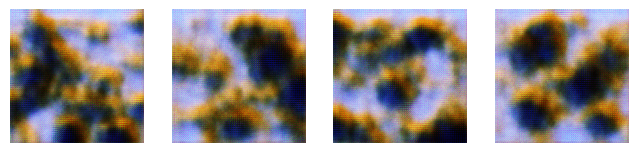

In [9]:
@torch.no_grad()
def show_batch(batch, n=16):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 8))
    for i, img in enumerate(batch[:n]):
        plt.subplot(int(n**0.5), int(n**0.5), i+1)
        plt.imshow((img.permute(1,2,0).cpu()+1)/2)
        plt.axis('off')
    plt.show()

# Demo with un-trained net – replace after training
rand = torch.randn(4, 3, 256, 256, device=device)
show_batch(G(rand))


In [10]:
SUBMIT_DIR = Path('generated_images'); SUBMIT_DIR.mkdir(exist_ok=True)
# TODO: generate 7 000–10 000 images with trained G → write directly to zip
with zipfile.ZipFile('images.zip', 'w', zipfile.ZIP_DEFLATED) as zf:
    pass  # zf.writestr(...)

print('✅  images.zip ready – upload via **Submit Prediction**!')


✅  images.zip ready – upload via **Submit Prediction**!


## 6 · Results & Discussion  
Record your public MiFID (keep it < 1 000) and note which tweaks improved or hurt performance.


## 7 · Next Steps  
- Longer training – MiFID keeps falling for ~10 epochs  
- Identity loss  – preserves colour harmony  
- Try Diffusion   – stable-diffusion fine-tune often beats GANs  


## 8 · References  
- Zhu et al. *CycleGAN* (2017)  
- Heusel et al. *TTUR & FID* (2017)  
- Amy Jang’s Kaggle starter  